Importamos las librerías

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Cargamos dataset de satelite

In [4]:
drive_path = '/content/drive/MyDrive/Colab Notebooks/'

In [5]:
!ls /content/drive/MyDrive/Colab\ Notebooks/

03_Series_Temporales_con_RNN.ipynb
13_Ejercicios_Recurrentes_Practica.ipynb
18_Practica_Obligatoria_Introduccion_Keras.ipynb
18_Practica_Obligatoria_Redes_Convolucionales_II__Transfer_Learning_y_Fine_Tuning.ipynb
bootcampviztools.py
catboost_info
COPERNICUS_GBOV_RM7_20253103525
data
GBOV_RM7_STER_STER_009_20150318T000000Z_20181010T132900Z_026_ACR_2.0.csv
Kaggle_submission_v10.ipynb
NEON_LAI_USA_2017_2024.csv
project_ML_insitu.ipynb
project_ML.ipynb
project_ML_sat.ipynb
project_ML_TOA_2017_2024.ipynb
project_ML_USA_EUROPE.ipynb
project_ML_v2.ipynb
project_ML_v3.ipynb
__pycache__
S2_SR_USA_2017_2024.csv
S2_SR_USA_2017_2024_SCL.csv
S2TOAreflectance_USA_LAI_2015_2024.csv
Sentinel2_SR_NEON_USA_LAI_2017_2024_backup.csv
Sentinel2_SR_NEON_USA_LAI_2017_2024.csv
Sentinel2_SR_NEON_USA_LAI_2017_2024_reduced.csv
Sentinel2_TOAreflectance_NEON_USA_LAI_2017_2024.csv


In [6]:
df_sat = pd.read_csv(drive_path + 'S2_SR_USA_2017_2024_SCL.csv', sep=',')

In [7]:
df_sat.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
df_sat.head()

,id,longitude,latitude,time,B1,B2,B3,B4,B5,B6,...,B8,B8A,B9,B11,B12,SCL,QA10,QA20,QA60,Site_sat
0,20171222T182749_20171222T183128_T12TUK,-112.452455,40.177600,1513967574868,3597.0,3704.0,3788.0,3972.0,4316.0,4280.0,...,4272.0,4349.0,4724.0,1167.0,1091.0,11.0,NaN,NaN,0,Onaqui Ault
1,20171118T170559_20171118T170554_T15TYL,-89.586378,45.508922,1511025045890,8393.0,8072.0,7776.0,7568.0,7652.0,7527.0,...,7632.0,7314.0,10924.0,2087.0,2396.0,8.0,NaN,NaN,1024,Steigerwaldt Land Services
2,20171225T165709_20171225T165708_T15TYL,-89.586378,45.508922,1514221250709,3381.0,3469.0,3256.0,3317.0,3473.0,3863.0,...,4376.0,4062.0,3881.0,2315.0,1911.0,9.0,NaN,NaN,2048,Steigerwaldt Land Services
3,20171118T170559_20171118T170554_T15SUD,-95.192225,39.040513,1511025161923,7635.0,7848.0,7632.0,7480.0,7621.0,7438.0,...,7944.0,7295.0,10781.0,1901.0,2098.0,8.0,NaN,NaN,1024,University of Kansas Field Site
4,20171118T170559_20171118T170554_T15TYM,-89.537510,46.234042,1511025031342,5584.0,5352.0,5124.0,5016.0,5094.0,5038.0,...,4980.0,4760.0,6066.0,3001.0,2600.0,9.0,NaN,NaN,1024,Underc


Convertimos a tipo datetime la columna 'time' que está formato Unix epoch time.

In [9]:
df_sat['time'] = df_sat['time'].apply(lambda x: dt.datetime.utcfromtimestamp(x / 1000))

Ordenamos el dataframe por Site y time, y reseteamos el indice.

In [10]:
df_sat.sort_values(by=['Site_sat','time'], inplace=True)
df_sat.reset_index(drop=True, inplace=True)

Eliminamos columnas innecesarias.  
QA10 y QA20 son columnas vacias.  
También descartamos las bandas de 60m que corresponden a aerosoles y vapor de agua: B1 y B9

In [11]:
df_sat.drop(columns=['B1', 'B9', 'QA10', 'QA20'], inplace=True)

In [12]:
df_sat.head()

,id,longitude,latitude,time,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,SCL,QA60,Site_sat
0,20180103T154629_20180103T154651_T18TYP,-71.287337,44.063892,2018-01-03 15:50:51.374,670.0,555.0,556.0,702.0,1291.0,1603.0,1448.0,1647.0,854.0,620.0,10.0,2048,Bartlett Experimental Forest
1,20180319T153941_20180319T153952_T19TCJ,-71.287337,44.063892,2018-03-19 15:50:53.419,1003.0,1133.0,1127.0,1198.0,1989.0,2271.0,2538.0,2407.0,882.0,580.0,5.0,2048,Bartlett Experimental Forest
2,20180319T153941_20180319T153952_T18TYP,-71.287337,44.063892,2018-03-19 15:50:57.571,525.0,670.0,821.0,1239.0,2013.0,2281.0,2163.0,2413.0,884.0,580.0,5.0,2048,Bartlett Experimental Forest
3,20180627T153911_20180627T154648_T19TCJ,-71.287337,44.063892,2018-06-27 15:50:57.171,2004.0,2130.0,1882.0,2485.0,3878.0,4306.0,4372.0,4374.0,1596.0,1270.0,8.0,2048,Bartlett Experimental Forest
4,20180627T153911_20180627T154648_T18TYP,-71.287337,44.063892,2018-06-27 15:51:01.324,1968.0,2062.0,1834.0,2166.0,3565.0,4148.0,4208.0,4327.0,1535.0,1099.0,8.0,2048,Bartlett Experimental Forest


In [13]:
df_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22975 entries, 0 to 22974
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         22975 non-null  object        
 1   longitude  22975 non-null  float64       
 2   latitude   22975 non-null  float64       
 3   time       22975 non-null  datetime64[ns]
 4   B2         22959 non-null  float64       
 5   B3         22960 non-null  float64       
 6   B4         22960 non-null  float64       
 7   B5         22960 non-null  float64       
 8   B6         22960 non-null  float64       
 9   B7         22960 non-null  float64       
 10  B8         22960 non-null  float64       
 11  B8A        22960 non-null  float64       
 12  B11        22960 non-null  float64       
 13  B12        22960 non-null  float64       
 14  SCL        22960 non-null  float64       
 15  QA60       22975 non-null  int64         
 16  Site_sat   22975 non-null  object       

Eliminamos las filas (espectros) correspondientes a pixeles con nubes  
Los pixes con nubes corresponden a: QA60 == 512 or QA60 == 1024 or QA60 == 2048  
Por lo tanto nos quedamos solo con los pixeles libres de nubes: QA60 == 0

In [14]:
len(df_sat) # Antes de eliminar filas vemos el tamaño del dataset

22975

In [15]:
df_sat['QA60'].value_counts() # También vemos la cantidad de pixeles con nubes

,count
QA60,
0,15915
1024,5244
2048,1816


In [16]:
df_sat = df_sat[df_sat['QA60'] == 0] # Me quedo con las filas (pixeles) libre de nubes

In [17]:
len(df_sat) # Vemos como queda el tamaño del dataset luego de eliminar pixeles con nubes

15915

In [18]:
df_sat = df_sat[df_sat['SCL'] == 4] # Me quedo con las filas (pixeles) de vegetación

Escalamos las bandas a los valores de reflectancia reales (originalmente están multiplicados por 10000).

In [19]:
bandas = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']

In [20]:
for banda in bandas:
    df_sat.loc[:,banda] = df_sat[banda].astype(float)
    df_sat.loc[:,banda] = df_sat[banda] * 0.0001

In [21]:
df_sat.head()

,id,longitude,latitude,time,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,SCL,QA60,Site_sat
23,20190128T154519_20190128T154758_T19TCJ,-71.287337,44.063892,2019-01-28 15:50:57.000,0.0543,0.0520,0.0584,0.0665,0.1536,0.1727,0.2460,0.2054,0.0793,0.0550,4.0,0,Bartlett Experimental Forest
24,20190128T154519_20190128T154758_T18TYP,-71.287337,44.063892,2019-01-28 15:51:01.000,0.0251,0.0346,0.0358,0.0649,0.1531,0.1739,0.2365,0.2108,0.0815,0.0570,4.0,0,Bartlett Experimental Forest
33,20190222T154241_20190222T154730_T19TCJ,-71.287337,44.063892,2019-02-22 15:50:52.000,0.0642,0.0854,0.0816,0.0890,0.1784,0.2129,0.2199,0.2268,0.1014,0.0616,4.0,0,Bartlett Experimental Forest
34,20190222T154241_20190222T154730_T18TYP,-71.287337,44.063892,2019-02-22 15:50:56.000,0.0438,0.0541,0.0619,0.0842,0.1787,0.2139,0.1845,0.2290,0.1034,0.0623,4.0,0,Bartlett Experimental Forest
63,20190508T153819_20190508T154933_T19TCJ,-71.287337,44.063892,2019-05-08 15:51:05.057,0.0388,0.0560,0.0564,0.0942,0.1683,0.1943,0.2432,0.2120,0.1615,0.0985,4.0,0,Bartlett Experimental Forest


Eliminamos outliers

In [22]:
'''# Función para eliminar outliers basado en el IQR
def eliminar_outliers_iqr(df, columnas):
    for columna in columnas:
        Q1 = df[columna].quantile(0.25)  # Primer cuartil
        Q3 = df[columna].quantile(0.75)  # Tercer cuartil
        IQR = Q3 - Q1  # Rango intercuartílico
        limite_inferior = Q1 - 1.5 * IQR  # Límite inferior
        limite_superior = Q3 + 1.5 * IQR  # Límite superior

        # Filtrar los datos que están fuera de los límites
        df = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]
    return df

# Eliminar outliers
df_sin_outliers = eliminar_outliers_iqr(df_sat, bandas)
df_sat = df_sin_outliers'''

'# Función para eliminar outliers basado en el IQR\ndef eliminar_outliers_iqr(df, columnas):\n    for columna in columnas:\n        Q1 = df[columna].quantile(0.25)  # Primer cuartil\n        Q3 = df[columna].quantile(0.75)  # Tercer cuartil\n        IQR = Q3 - Q1  # Rango intercuartílico\n        limite_inferior = Q1 - 1.5 * IQR  # Límite inferior\n        limite_superior = Q3 + 1.5 * IQR  # Límite superior\n\n        # Filtrar los datos que están fuera de los límites\n        df = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]\n    return df\n\n# Eliminar outliers\ndf_sin_outliers = eliminar_outliers_iqr(df_sat, bandas)\ndf_sat = df_sin_outliers'

Visualizamos muestras de los espectros de vegetación en un gráfico

In [23]:
# Definimos la longitud de on central de las bandas
longitudes_de_onda = {
    'B2': 490,  # Banda 2 (Azul)
    'B3': 560,  # Banda 3 (Verde)
    'B4': 665,  # Banda 4 (Rojo)
    'B5': 705,  # Banda 5
    'B6': 740,  # Banda 6
    'B7': 783,  # Banda 7
    'B8': 842,  # Banda 8 (Infrarrojo cercano)
    'B8A': 865, # Banda 8A
    'B11': 1610, # Banda 11 (Infrarrojo de onda corta)
    'B12': 2190  # Banda 12
}

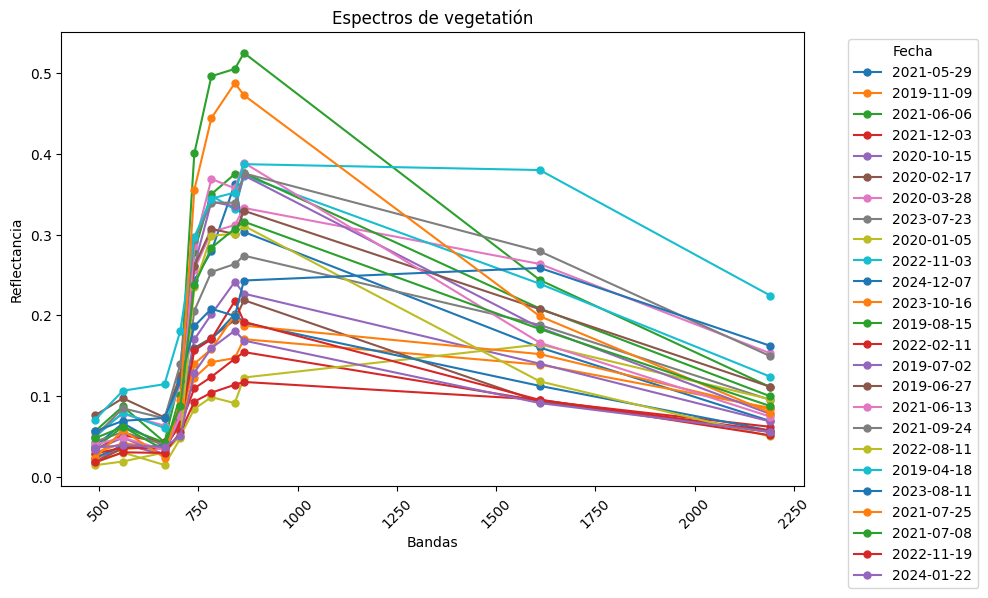

In [24]:
import matplotlib.pyplot as plt

# Graficar diferentes espectros
plt.figure(figsize=(10, 6))  # Definir tamaño de la figura

for index, row in df_sat.sample(25).iterrows():
    plt.plot([longitudes_de_onda[band] for band in bandas], row[bandas], label=row['time'].strftime('%Y-%m-%d'), marker='o', linestyle='-', markersize=5)

# Configuración del gráfico
plt.title("Espectros de vegetatión")
plt.xlabel("Bandas")
plt.ylabel("Reflectancia")
plt.legend(title="Fecha", bbox_to_anchor=(1.05, 1), loc='upper left')  # Mueve la leyenda fuera de la gráfica

# Mostrar gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas de las bandas
plt.tight_layout()  # Ajustar el espacio
plt.show();

Calculamos el NDVI y graficamos series temporales de muestras de pixeles para verificar que se aproxima a la realidad

In [25]:
'''# Calcular NDVI para cada fila del DataFrame
df_sat['NDVI'] = (df_sat['B8'] - df_sat['B4']) / (df_sat['B8'] + df_sat['B4'])

# Graficar el NDVI para cada fecha
plt.figure(figsize=(12, 6))
plt.plot(df_sat['time'][100], df_sat['NDVI'][100], marker='o', linestyle='-', markersize=5)

# Configuración del gráfico
plt.title("NDVI de Vegetación usando Sentinel-2")
plt.xlabel("Fecha")
plt.ylabel("Valor de NDVI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()'''

'# Calcular NDVI para cada fila del DataFrame\ndf_sat[\'NDVI\'] = (df_sat[\'B8\'] - df_sat[\'B4\']) / (df_sat[\'B8\'] + df_sat[\'B4\'])\n\n# Graficar el NDVI para cada fecha\nplt.figure(figsize=(12, 6))\nplt.plot(df_sat[\'time\'][100], df_sat[\'NDVI\'][100], marker=\'o\', linestyle=\'-\', markersize=5)\n\n# Configuración del gráfico\nplt.title("NDVI de Vegetación usando Sentinel-2")\nplt.xlabel("Fecha")\nplt.ylabel("Valor de NDVI")\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()'

Image of vegetation phenology

![Image of vegetation phenology](https://www.scielo.org.mx/img/revistas/tl/v36n4//2395-8030-tl-36-04-393-gf1.png)

### Medidas insitu

Cargamos dataset de medidas in-situ

In [26]:
!ls /content/drive/MyDrive/Colab\ Notebooks/

03_Series_Temporales_con_RNN.ipynb
13_Ejercicios_Recurrentes_Practica.ipynb
18_Practica_Obligatoria_Introduccion_Keras.ipynb
18_Practica_Obligatoria_Redes_Convolucionales_II__Transfer_Learning_y_Fine_Tuning.ipynb
bootcampviztools.py
catboost_info
COPERNICUS_GBOV_RM7_20253103525
data
GBOV_RM7_STER_STER_009_20150318T000000Z_20181010T132900Z_026_ACR_2.0.csv
Kaggle_submission_v10.ipynb
NEON_LAI_USA_2017_2024.csv
project_ML_insitu.ipynb
project_ML.ipynb
project_ML_sat.ipynb
project_ML_TOA_2017_2024.ipynb
project_ML_USA_EUROPE.ipynb
project_ML_v2.ipynb
project_ML_v3.ipynb
__pycache__
S2_SR_USA_2017_2024.csv
S2_SR_USA_2017_2024_SCL.csv
S2TOAreflectance_USA_LAI_2015_2024.csv
Sentinel2_SR_NEON_USA_LAI_2017_2024_backup.csv
Sentinel2_SR_NEON_USA_LAI_2017_2024.csv
Sentinel2_SR_NEON_USA_LAI_2017_2024_reduced.csv
Sentinel2_TOAreflectance_NEON_USA_LAI_2017_2024.csv


In [27]:
df_insitu = pd.read_csv(drive_path + 'NEON_LAI_USA_2017_2024.csv', sep=',')

In [28]:
df_insitu.drop(columns=['Unnamed: 0'], inplace=True)

In [29]:
df_insitu.head()

,GBOV_ID,Site,GROUND_DATA_PI,GROUND_DATA_PIs_Email,GBOV_Email,Network,Elevation,IGBP_class,Lat_IS,Lon_IS,...,LAI_Miller_down_err,LAI_Warren_down_err,LAIe_Miller_down_err,LAIe_Warren_down_err,clumping_Miller_down,clumping_Warren_down,clumping_Miller_up_err,clumping_Warren_up_err,clumping_Miller_down_err,clumping_Warren_down_err
0,GBOV_RM7_1223,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.027,0.04,0.017,0.022,0.75,0.80,0.029,0.04,0.11,0.19
1,GBOV_RM7_1223,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GBOV_RM7_1235,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.11,0.18,0.07,0.11,0.76,0.74,0.033,0.05,0.08,0.17
3,GBOV_RM7_1235,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GBOV_RM7_1244,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.21,0.32,0.14,0.22,0.64,0.67,0.035,0.06,0.07,0.16


Limpieza inicial

In [30]:
'''columnas_sel = [
 'GBOV_ID',
 'Site',
 'Network',
 'Elevation',
 'IGBP_class',
 'Lat_IS',
 'Lon_IS',
 'TIME_IS',
 'Version',
 'up_flag',
 'down_flag',
 'LAIe_Miller_up',
 'LAIe_Miller_down',
 'LAIe_Miller_up_err',
 'LAIe_Miller_down_err']'''


"columnas_sel = [\n 'GBOV_ID',\n 'Site',\n 'Network',\n 'Elevation',\n 'IGBP_class',\n 'Lat_IS',\n 'Lon_IS',\n 'TIME_IS',\n 'Version',\n 'up_flag',\n 'down_flag',\n 'LAIe_Miller_up',\n 'LAIe_Miller_down',\n 'LAIe_Miller_up_err',\n 'LAIe_Miller_down_err']"

Eliminamos columnas innecesarias

In [31]:
#df_insitu.drop([col for col in df_insitu.columns if col not in columnas_sel], axis=1, inplace=True)

In [32]:
df_insitu[df_insitu.LAI_Miller_down_err == '-999.0']

,GBOV_ID,Site,GROUND_DATA_PI,GROUND_DATA_PIs_Email,GBOV_Email,Network,Elevation,IGBP_class,Lat_IS,Lon_IS,...,LAI_Miller_down_err,LAI_Warren_down_err,LAIe_Miller_down_err,LAIe_Warren_down_err,clumping_Miller_down,clumping_Warren_down,clumping_Miller_up_err,clumping_Warren_up_err,clumping_Miller_down_err,clumping_Warren_down_err
139,GBOV_RM7_187,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.537800,-72.171501,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.018694,0.043113,-999.0,-999.0
495,GBOV_RM7_889,Jones Ecological Research Center,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,44,Evergreen Needleleaf,31.194839,-84.468777,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.040000,0.070000,-999.0,-999.0
511,GBOV_RM7_889,Jones Ecological Research Center,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,44,Evergreen Needleleaf,31.194839,-84.468777,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.044502,0.063021,-999.0,-999.0
625,GBOV_RM7_393,Jones Ecological Research Center,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,44,Evergreen Needleleaf,31.194839,-84.468777,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.030000,0.040000,-999.0,-999.0
1577,GBOV_RM7_1578,Lajas Experimental Station,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,24,Grasslands,18.021250,-67.076900,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.017226,0.043781,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7979,GBOV_RM7_181,Blandy Experimental Farm,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,183,Deciduous Broadleaf,39.060261,-78.071640,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.030000,0.050000,-999.0,-999.0
7980,GBOV_RM7_181,Blandy Experimental Farm,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,183,Deciduous Broadleaf,39.060261,-78.071640,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.031000,0.040000,-999.0,-999.0
7981,GBOV_RM7_181,Blandy Experimental Farm,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,183,Deciduous Broadleaf,39.060261,-78.071640,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.029000,0.040000,-999.0,-999.0
7982,GBOV_RM7_181,Blandy Experimental Farm,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,183,Deciduous Broadleaf,39.060261,-78.071640,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.029000,0.040000,-999.0,-999.0


Eliminamos filas antes de calcular el LAI

In [33]:
# Reemplazar todos los valores -999 por NaN
df_insitu.replace(-999.0, np.nan, inplace=True)
len(df_insitu)

9406

In [34]:
# Reemplazar todos los valores -999 por NaN
df_insitu.replace('-999.0', np.nan, inplace=True)
len(df_insitu)

9406

In [35]:
#Eliminamos las filas vacias
df_insitu.dropna(how = 'all', inplace=True)
len(df_insitu)

9406

Preparamos filas antes de calcular el LAI

In [36]:
# Asignamos valor nulo a las up_flags diferente de cero.
# Nos quedamos con las quality flags=0 que son las que garantizan mejor calidad de las medidas
mask_invalid_up = df_insitu['up_flag'] != 0
df_insitu.loc[mask_invalid_up,['up_flag','LAIe_Miller_up','LAIe_Miller_up_err']] = np.nan

In [37]:
# Asignamos valor nulo a las down_flags diferente de cero.
# Nos quedamos con las quality flags=0 que son las que garantizan mejor calidad de las medidas
mask_invalid_down = df_insitu['down_flag'] != 0
df_insitu.loc[mask_invalid_down,['down_flag','LAIe_Miller_down','LAIe_Miller_down_err']] = np.nan

In [38]:
# Eliminamos filas donde las flags son nulas
df_insitu.dropna(subset=['up_flag','down_flag'], how='all', inplace=True)
len(df_insitu)

7486

Limpiamos las columnas numericas de caracteres indeseados.  


In [39]:
#Eliminamos los parentesis que aparezcan.
#df_insitu['LAIe_Miller_up'] = df_insitu['LAIe_Miller_up'].str.replace('(', '').str.replace(')', '')
df_insitu['LAIe_Miller_down'] = df_insitu['LAIe_Miller_down'].str.replace('(', '').str.replace(')', '')
#df_insitu['LAIe_Miller_up_err'] = df_insitu['LAIe_Miller_up_err'].str.replace('(', '').str.replace(')', '')
df_insitu['LAIe_Miller_down_err'] = df_insitu['LAIe_Miller_down_err'].str.replace('(', '').str.replace(')', '')

Convertimos a float las columnas numericas necesarias para calcular LAI

In [40]:
# Verificar y convertir solo si la columna no es de tipo float
if df_insitu['LAIe_Miller_up'].dtype != 'float':
    df_insitu['LAIe_Miller_up'] = df_insitu['LAIe_Miller_up'].astype(float)

if df_insitu['LAIe_Miller_down'].dtype != 'float':
    df_insitu['LAIe_Miller_down'] = df_insitu['LAIe_Miller_down'].astype(float)

if df_insitu['LAIe_Miller_up_err'].dtype != 'float':
    df_insitu['LAIe_Miller_up_err'] = df_insitu['LAIe_Miller_up_err'].astype(float)

if df_insitu['LAIe_Miller_down_err'].dtype != 'float':
    df_insitu['LAIe_Miller_down_err'] = df_insitu['LAIe_Miller_down_err'].astype(float)

Calculamos el LAI effective y el error de LAI effective

In [41]:
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'LAIe_Miller'] = df_insitu['LAIe_Miller_up'] + df_insitu['LAIe_Miller_down']
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'LAIe_Miller_err'] = df_insitu['LAIe_Miller_up_err'] + df_insitu['LAIe_Miller_down_err']

df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()), 'LAIe_Miller'] = df_insitu['LAIe_Miller_up']
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()), 'LAIe_Miller_err'] = df_insitu['LAIe_Miller_up_err']

df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0), 'LAIe_Miller'] = df_insitu['LAIe_Miller_down']
df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0), 'LAIe_Miller_err'] = df_insitu['LAIe_Miller_down_err']

In [42]:
# Eliminamos las filas donde el LAI es nulo
df_insitu.dropna(subset=['LAIe_Miller'], inplace=True)
len(df_insitu)

7155

In [43]:
df_insitu.head()

,GBOV_ID,Site,GROUND_DATA_PI,GROUND_DATA_PIs_Email,GBOV_Email,Network,Elevation,IGBP_class,Lat_IS,Lon_IS,...,LAIe_Miller_down_err,LAIe_Warren_down_err,clumping_Miller_down,clumping_Warren_down,clumping_Miller_up_err,clumping_Warren_up_err,clumping_Miller_down_err,clumping_Warren_down_err,LAIe_Miller,LAIe_Miller_err
0,GBOV_RM7_1223,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.017,0.022,0.75,0.80,0.029,0.04,0.11,0.19,3.013,0.107
2,GBOV_RM7_1235,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.070,0.11,0.76,0.74,0.033,0.05,0.08,0.17,4.030,0.190
4,GBOV_RM7_1244,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.140,0.22,0.64,0.67,0.035,0.06,0.07,0.16,4.880,0.260
6,GBOV_RM7_1211,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.090,0.12,0.74,0.79,0.029,0.05,0.05,0.09,5.540,0.200
8,GBOV_RM7_1253,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.060,0.07,0.77,0.83,0.030,0.05,0.08,0.14,4.940,0.190


In [44]:
df_insitu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7155 entries, 0 to 9404
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   GBOV_ID                   7155 non-null   object 
 1   Site                      7155 non-null   object 
 2   GROUND_DATA_PI            6937 non-null   object 
 3   GROUND_DATA_PIs_Email     6937 non-null   object 
 4   GBOV_Email                7155 non-null   object 
 5   Network                   7155 non-null   object 
 6   Elevation                 7155 non-null   int64  
 7   IGBP_class                7155 non-null   object 
 8   Lat_IS                    7155 non-null   float64
 9   Lon_IS                    7155 non-null   float64
 10  TIME_IS                   7155 non-null   object 
 11  Version                   7155 non-null   float64
 12  up_flag                   4273 non-null   float64
 13  down_flag                 6668 non-null   float64
 14  LAI_Miller_up

### Hacemos el merge de los dos datasets

In [45]:
# Convertimos la columna de la fecha a formato datetime.
df_insitu['TIME_IS'] = pd.to_datetime(df_insitu['TIME_IS']).dt.tz_localize(None)

In [46]:
df_insitu.TIME_IS

,TIME_IS
0,2018-08-13
2,2018-08-13
4,2018-08-13
6,2018-08-13
8,2018-08-13
...,...
9396,2018-08-14
9398,2018-08-14
9400,2018-08-15
9402,2018-08-13


In [47]:
df_coord = df_insitu[['Site','Lat_IS', 'Lon_IS']].drop_duplicates()
coordenadas = tuple(zip(df_coord['Site'].values.tolist(), df_coord['Lat_IS'].values.tolist(), df_coord['Lon_IS'].values.tolist()))
coordenadas

(('Harvard Forest', 42.5377998352051, -72.171501159668),
 ('Jones Ecological Research Center', 31.1948394775391, -84.468777),
 ('Jornada', 32.5907, -106.84261),
 ('Konza Prairie Biological Station', 39.110446, -96.612935),
 ('Lajas Experimental Station', 18.02125, -67.0769),
 ('Lenoir Landing', 31.853861, -88.161181),
 ('Moab', 38.24836, -109.38831),
 ('Niwot Ridge Mountain Research Station', 40.0543, -105.58245),
 ('Onaqui Ault', 40.1775894165039, -112.452438354492),
 ('Oak Ridge', 35.9641189575195, -84.282600402832),
 ('Ordway Swisher Biological Station', 29.6839, -81.9934),
 ('Pu u Maka ala Natural Area Reserve', 19.55309, -155.31731),
 ('Smithsonian Conservation Biology Institute',
  38.8929214477539,
  -78.1395034790039),
 ('Smithsonian Environmental Research Center', 38.89016, -76.5601),
 ('Soaproot Saddle', 37.03337, -119.26219),
 ('Santa Rita', 31.91068, -110.83549),
 ('Steigerwaldt Land Services', 45.5089416503906, -89.5863723754883),
 ('North Sterling', 40.461952, -103.02934)

Para cada site identificamos las medidas in_situ mas cercanas a la fecha de adquisicion del satélite

In [48]:
df_list = []

# Itera sobre cada coordenada
for site, lat, lon in coordenadas:
    # Filtra el DataFrame de df_insitu y df según el 'Site'
    df_insitu_site = df_insitu[df_insitu['Site'] == site]
    df_sat_site = df_sat[df_sat['Site_sat'] == site]

    rows = []

    # Itera sobre los datos de satélite y datos in situ
    for index_sat, date_sat in df_sat_site['time'].items():
        for index_insitu, date_insitu in df_insitu_site['TIME_IS'].items():
            # Calcula la diferencia en días entre las fechas
            dif = (date_insitu - date_sat) / np.timedelta64(1, 'D')

            if abs(dif) <= 7:
                # Crea una lista con la fila combinada de ambas fuentes
                row = list(df_sat_site.loc[index_sat]) + list(df_insitu_site.loc[index_insitu])
                rows.append(row)

    # Si se encontraron filas, procesa los datos
    if rows:
        # Crear el DataFrame con las filas acumuladas
        df_cross_site = pd.DataFrame(rows, columns=list(df_sat_site.columns) + list(df_insitu_site.columns))

        # Añadir una columna 'delta' con la diferencia en tiempo entre el satélite y las mediciones in situ
        df_cross_site['delta'] = abs(df_cross_site['time'] - df_cross_site['TIME_IS'])

        # Añadir las fechas separadas de 'date_sat' y 'date_insitu'
        df_cross_site['date_sat'] = df_cross_site['time'].dt.date
        df_cross_site['date_insitu'] = df_cross_site['TIME_IS'].dt.date

        # Ordenar y eliminar duplicados por 'date_insitu'
        df_cross_site = df_cross_site.sort_values(by=['date_insitu', 'delta']).drop_duplicates(subset='date_insitu', keep='first')

        # Ordenar y eliminar duplicados por 'date_sat'
        df_cross_site = df_cross_site.sort_values(by=['date_sat', 'delta']).drop_duplicates(subset='date_sat', keep='first')



        # Agregar el DataFrame de este sitio a la lista
        df_list.append(df_cross_site)

# Combinar todos los DataFrames en uno solo
df_cross = pd.concat(df_list, axis=0, ignore_index=True)

# Mostrar el DataFrame final
df_cross

,id,longitude,latitude,time,B2,B3,B4,B5,B6,B7,...,clumping_Warren_down,clumping_Miller_up_err,clumping_Warren_up_err,clumping_Miller_down_err,clumping_Warren_down_err,LAIe_Miller,LAIe_Miller_err,delta,date_sat,date_insitu
0,20190607T153819_20190607T154303_T18TYN,-72.171458,42.537834,2019-06-07 15:51:23.000,0.0198,0.0532,0.0169,0.0982,0.3507,0.4087,...,0.860000,0.029000,0.040000,0.090000,0.150000,3.933000,0.111000,3 days 10:17:23,2019-06-07,2019-06-04
1,20190627T153819_20190627T154123_T18TYN,-72.171458,42.537834,2019-06-27 15:51:23.000,0.0236,0.0405,0.0193,0.0782,0.3244,0.4116,...,0.900000,0.027000,0.040000,0.100000,0.190000,4.247000,0.126000,4 days 13:44:37,2019-06-27,2019-07-02
2,20190712T153911_20190712T154425_T18TYN,-72.171458,42.537834,2019-07-12 15:51:20.431,0.0197,0.0203,0.0126,0.0247,0.0888,0.1154,...,0.910000,0.027000,0.040000,0.110000,0.180000,3.585000,0.111000,3 days 13:53:39.569000,2019-07-12,2019-07-16
3,20190801T153911_20190801T154113_T18TYN,-72.171458,42.537834,2019-08-01 15:51:19.875,0.0176,0.0422,0.0188,0.0757,0.3112,0.3827,...,0.780000,0.030000,0.050000,0.080000,0.150000,3.704000,0.110000,2 days 09:45:19.875000,2019-08-01,2019-07-30
4,20190826T153819_20190826T154455_T18TYN,-72.171458,42.537834,2019-08-26 15:51:19.743,0.0204,0.0405,0.0182,0.0711,0.2746,0.3450,...,0.960000,0.029000,0.050000,0.060000,0.090000,3.868000,0.106000,0 days 14:23:40.257000,2019-08-26,2019-08-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,20220702T155831_20220702T160658_T17RMM,-81.436323,28.125084,2022-07-02 16:15:42.120,0.0766,0.1068,0.0961,0.1680,0.2857,0.3193,...,0.916421,NaN,NaN,0.035652,0.070347,1.364178,0.035036,4 days 01:28:42.120000,2022-07-02,2022-06-28
975,20220712T155921_20220712T161132_T17RMM,-81.436323,28.125084,2022-07-12 16:15:41.829,0.0635,0.1009,0.0870,0.1681,0.2862,0.3219,...,0.896217,NaN,NaN,0.045395,0.080408,1.222026,0.044633,0 days 18:33:18.171000,2022-07-12,2022-07-13
976,20220816T155829_20220816T160800_T17RMM,-81.436323,28.125084,2022-08-16 16:15:31.606,0.0564,0.0855,0.0732,0.1374,0.2510,0.2895,...,0.923436,NaN,NaN,0.058342,0.108301,0.768703,0.032030,6 days 05:13:31.606000,2022-08-16,2022-08-10
977,20220920T155941_20220920T161148_T17RMM,-81.436323,28.125084,2022-09-20 16:15:36.754,0.0382,0.0654,0.0550,0.1176,0.2080,0.2392,...,0.934136,NaN,NaN,0.053466,0.082737,0.719390,0.027673,0 days 18:10:23.246000,2022-09-20,2022-09-21


In [49]:
#df_cross.sort_index()[['Site','id','date_sat','date_insitu','time','TIME_IS','delta']]

In [50]:
#df_cross = df_cross.sort_values(by = ['Site','time']).reset_index(drop=True)

In [51]:
df_cross[['Site','id','date_sat','date_insitu','time','TIME_IS','delta']]

,Site,id,date_sat,date_insitu,time,TIME_IS,delta
0,Harvard Forest,20190607T153819_20190607T154303_T18TYN,2019-06-07,2019-06-04,2019-06-07 15:51:23.000,2019-06-04 05:34:00,3 days 10:17:23
1,Harvard Forest,20190627T153819_20190627T154123_T18TYN,2019-06-27,2019-07-02,2019-06-27 15:51:23.000,2019-07-02 05:36:00,4 days 13:44:37
2,Harvard Forest,20190712T153911_20190712T154425_T18TYN,2019-07-12,2019-07-16,2019-07-12 15:51:20.431,2019-07-16 05:45:00,3 days 13:53:39.569000
3,Harvard Forest,20190801T153911_20190801T154113_T18TYN,2019-08-01,2019-07-30,2019-08-01 15:51:19.875,2019-07-30 06:06:00,2 days 09:45:19.875000
4,Harvard Forest,20190826T153819_20190826T154455_T18TYN,2019-08-26,2019-08-27,2019-08-26 15:51:19.743,2019-08-27 06:15:00,0 days 14:23:40.257000
...,...,...,...,...,...,...,...
974,Disney Wilderness Preserve,20220702T155831_20220702T160658_T17RMM,2022-07-02,2022-06-28,2022-07-02 16:15:42.120,2022-06-28 14:47:00,4 days 01:28:42.120000
975,Disney Wilderness Preserve,20220712T155921_20220712T161132_T17RMM,2022-07-12,2022-07-13,2022-07-12 16:15:41.829,2022-07-13 10:49:00,0 days 18:33:18.171000
976,Disney Wilderness Preserve,20220816T155829_20220816T160800_T17RMM,2022-08-16,2022-08-10,2022-08-16 16:15:31.606,2022-08-10 11:02:00,6 days 05:13:31.606000
977,Disney Wilderness Preserve,20220920T155941_20220920T161148_T17RMM,2022-09-20,2022-09-21,2022-09-20 16:15:36.754,2022-09-21 10:26:00,0 days 18:10:23.246000


Seleccion de features

In [52]:
features_sel = ['Site',
 'Lat_IS',
 'Lon_IS',
 'date_sat',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B11',
 'B12',
 'NDVI',
 'Network',
 'Elevation',
 'IGBP_class',
 'date_insitu',
 'delta',
 'LAIe_Miller',
 'LAIe_Miller_err']

In [53]:
#df_cross = df_cross[features_sel]

In [54]:
df_cross

,id,longitude,latitude,time,B2,B3,B4,B5,B6,B7,...,clumping_Warren_down,clumping_Miller_up_err,clumping_Warren_up_err,clumping_Miller_down_err,clumping_Warren_down_err,LAIe_Miller,LAIe_Miller_err,delta,date_sat,date_insitu
0,20190607T153819_20190607T154303_T18TYN,-72.171458,42.537834,2019-06-07 15:51:23.000,0.0198,0.0532,0.0169,0.0982,0.3507,0.4087,...,0.860000,0.029000,0.040000,0.090000,0.150000,3.933000,0.111000,3 days 10:17:23,2019-06-07,2019-06-04
1,20190627T153819_20190627T154123_T18TYN,-72.171458,42.537834,2019-06-27 15:51:23.000,0.0236,0.0405,0.0193,0.0782,0.3244,0.4116,...,0.900000,0.027000,0.040000,0.100000,0.190000,4.247000,0.126000,4 days 13:44:37,2019-06-27,2019-07-02
2,20190712T153911_20190712T154425_T18TYN,-72.171458,42.537834,2019-07-12 15:51:20.431,0.0197,0.0203,0.0126,0.0247,0.0888,0.1154,...,0.910000,0.027000,0.040000,0.110000,0.180000,3.585000,0.111000,3 days 13:53:39.569000,2019-07-12,2019-07-16
3,20190801T153911_20190801T154113_T18TYN,-72.171458,42.537834,2019-08-01 15:51:19.875,0.0176,0.0422,0.0188,0.0757,0.3112,0.3827,...,0.780000,0.030000,0.050000,0.080000,0.150000,3.704000,0.110000,2 days 09:45:19.875000,2019-08-01,2019-07-30
4,20190826T153819_20190826T154455_T18TYN,-72.171458,42.537834,2019-08-26 15:51:19.743,0.0204,0.0405,0.0182,0.0711,0.2746,0.3450,...,0.960000,0.029000,0.050000,0.060000,0.090000,3.868000,0.106000,0 days 14:23:40.257000,2019-08-26,2019-08-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,20220702T155831_20220702T160658_T17RMM,-81.436323,28.125084,2022-07-02 16:15:42.120,0.0766,0.1068,0.0961,0.1680,0.2857,0.3193,...,0.916421,NaN,NaN,0.035652,0.070347,1.364178,0.035036,4 days 01:28:42.120000,2022-07-02,2022-06-28
975,20220712T155921_20220712T161132_T17RMM,-81.436323,28.125084,2022-07-12 16:15:41.829,0.0635,0.1009,0.0870,0.1681,0.2862,0.3219,...,0.896217,NaN,NaN,0.045395,0.080408,1.222026,0.044633,0 days 18:33:18.171000,2022-07-12,2022-07-13
976,20220816T155829_20220816T160800_T17RMM,-81.436323,28.125084,2022-08-16 16:15:31.606,0.0564,0.0855,0.0732,0.1374,0.2510,0.2895,...,0.923436,NaN,NaN,0.058342,0.108301,0.768703,0.032030,6 days 05:13:31.606000,2022-08-16,2022-08-10
977,20220920T155941_20220920T161148_T17RMM,-81.436323,28.125084,2022-09-20 16:15:36.754,0.0382,0.0654,0.0550,0.1176,0.2080,0.2392,...,0.934136,NaN,NaN,0.053466,0.082737,0.719390,0.027673,0 days 18:10:23.246000,2022-09-20,2022-09-21


In [55]:
df_cross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979 entries, 0 to 978
Data columns (total 60 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   id                        979 non-null    object         
 1   longitude                 979 non-null    float64        
 2   latitude                  979 non-null    float64        
 3   time                      979 non-null    datetime64[ns] 
 4   B2                        979 non-null    float64        
 5   B3                        979 non-null    float64        
 6   B4                        979 non-null    float64        
 7   B5                        979 non-null    float64        
 8   B6                        979 non-null    float64        
 9   B7                        979 non-null    float64        
 10  B8                        979 non-null    float64        
 11  B8A                       979 non-null    float64        
 12  B11     

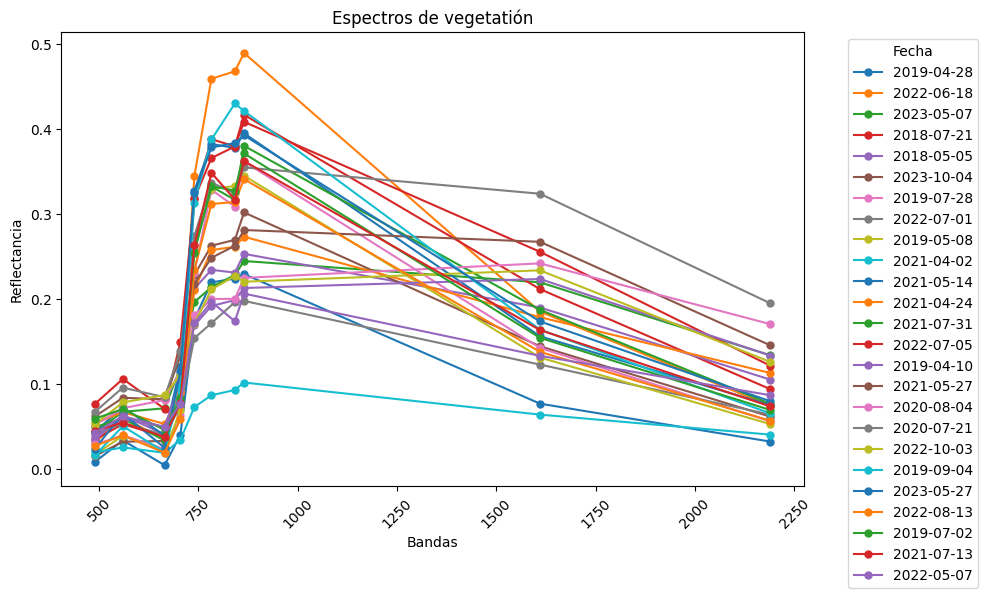

In [56]:
import matplotlib.pyplot as plt

# Graficar diferentes espectros
plt.figure(figsize=(10, 6))  # Definir tamaño de la figura

for index, row in df_cross.sample(25).iterrows():
    plt.plot([longitudes_de_onda[band] for band in bandas], row[bandas], label=row['date_sat'].strftime('%Y-%m-%d'), marker='o', linestyle='-', markersize=5)

# Configuración del gráfico
plt.title("Espectros de vegetatión")
plt.xlabel("Bandas")
plt.ylabel("Reflectancia")
plt.legend(title="Fecha", bbox_to_anchor=(1.05, 1), loc='upper left')  # Mueve la leyenda fuera de la gráfica

# Mostrar gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas de las bandas
plt.tight_layout()  # Ajustar el espacio
plt.show()

<ipython-input-57-5fb423a7abaf>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')  # Elegir un mapa de colores (puedes cambiar 'viridis' por otro mapa como 'plasma', 'inferno', etc.)


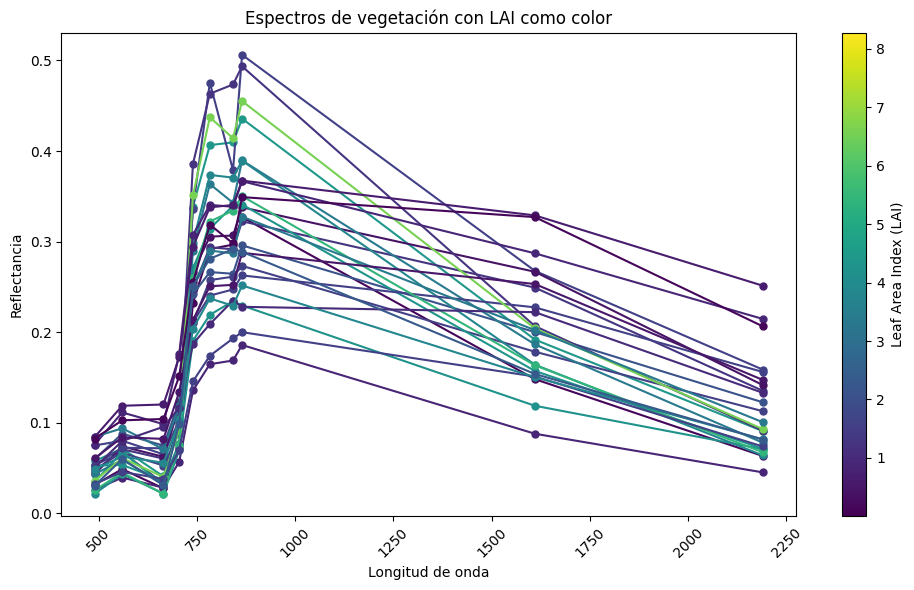

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Graficar diferentes espectros
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes object

# Crear una lista de colores basada en el valor de LAI
cmap = cm.get_cmap('viridis')  # Elegir un mapa de colores (puedes cambiar 'viridis' por otro mapa como 'plasma', 'inferno', etc.)
norm = plt.Normalize(df_cross['LAIe_Miller'].min(), df_cross['LAIe_Miller'].max())  # Normalizar el rango del LAI

for index, row in df_cross.sample(25).iterrows():
    # Obtener el valor del LAI para esta fila
    lai_value = row['LAIe_Miller']

    # Mapear el valor de LAI a un color
    color = cmap(norm(lai_value))  # Obtener el color correspondiente al LAI

    # Graficar el espectro, usando el valor del LAI como color de la línea
    ax.plot([longitudes_de_onda[band] for band in bandas], row[bandas], label=row['date_sat'].strftime('%Y-%m-%d'),
             marker='o', linestyle='-', markersize=5, color=color)

# Añadir barra de colores para mostrar la escala del LAI
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para la barra de colores
fig.colorbar(sm, ax=ax, label='Leaf Area Index (LAI)') # Associate colorbar with the axes

# Configuración del gráfico
ax.set_title("Espectros de vegetación con LAI como color") # Use ax.set_title instead of plt.title
ax.set_xlabel("Longitud de onda") # Use ax.set_xlabel instead of plt.xlabel
ax.set_ylabel("Reflectancia") # Use ax.set_ylabel instead of plt.ylabel
#ax.legend(title="Fecha", bbox_to_anchor=(1.05, 1), loc='upper left')  # Mueve la leyenda fuera de la gráfica

# Mostrar gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas de las bandas
plt.tight_layout()  # Ajustar el espacio
plt.show()

In [58]:
df_cross.describe()

,longitude,latitude,time,B2,B3,B4,B5,B6,B7,B8,...,LAIe_Miller_down_err,clumping_Miller_down,clumping_Warren_down,clumping_Miller_up_err,clumping_Warren_up_err,clumping_Miller_down_err,clumping_Warren_down_err,LAIe_Miller,LAIe_Miller_err,delta
count,979.000000,979.000000,979,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,...,901.000000,937.000000,937.000000,775.000000,775.000000,937.000000,937.000000,979.000000,979.000000,979
mean,-90.200865,34.672331,2021-02-06 01:29:16.194924544,0.041017,0.061695,0.047658,0.097411,0.240987,0.289154,0.292485,...,0.037871,0.860389,0.871041,0.039301,0.061130,0.083213,0.149202,2.662578,0.096016,2 days 10:43:53.621204290
min,-155.317365,18.021193,2018-03-14 16:44:19.527000,0.006100,0.016300,0.004000,0.020600,0.072500,0.086400,0.091000,...,0.001011,0.460000,0.480000,0.014651,0.027582,0.021669,0.040000,0.007038,0.001041,0 days 00:03:31.465000
25%,-95.192225,31.194807,2019-09-01 19:11:28.741000192,0.026650,0.044800,0.027100,0.073450,0.187400,0.216150,0.225400,...,0.016000,0.803627,0.815998,0.025823,0.041218,0.054541,0.094961,0.912848,0.043186,0 days 22:31:17.251500
50%,-84.468856,35.964142,2021-05-13 16:12:22.991000064,0.036700,0.058000,0.039200,0.092600,0.240300,0.284200,0.286600,...,0.027780,0.880000,0.890000,0.030000,0.050000,0.072720,0.131208,2.720000,0.090000,2 days 00:48:51.001000
75%,-78.071593,39.110402,2022-05-20 17:17:45.363500032,0.051750,0.074750,0.061350,0.117450,0.287250,0.350450,0.349800,...,0.050000,0.938771,0.945743,0.040000,0.064971,0.100000,0.182978,4.075004,0.134050,3 days 15:50:04.012500
max,-67.076933,47.128225,2023-12-09 16:15:10.948000,0.140000,0.161400,0.162000,0.209700,0.524400,0.621300,0.643700,...,0.290000,0.991323,0.995928,0.232601,0.238642,0.350937,0.747748,8.272813,0.400000,6 days 22:39:01.239000
std,21.374807,8.379900,NaN,0.020127,0.023276,0.026948,0.031956,0.075334,0.095582,0.094806,...,0.034798,0.094800,0.093066,0.029527,0.032533,0.041969,0.077681,1.780774,0.062640,1 days 18:50:28.281731516


Exportamos el dataframe a un archivo csv

In [59]:
df_cross.to_csv(drive_path + 'Sentinel2_SR_NEON_USA_LAI_2017_2024.csv')

### Mini EDA

Dividimos en train y test

In [60]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_cross, test_size=0.2, random_state=42)
print(len(train_set))
print(len(test_set))

783
196


Definimos el target y las features

In [61]:
target = 'LAIe_Miller'

In [62]:
features = bandas
features

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

Definimos X_train, y_train

In [63]:
X_train = train_set[features]
y_train = train_set[target]

X_test = test_set[features]
y_test = test_set[target]

Vemos las features (bandas) mas correlacionadas con el target

In [64]:
corr = train_set[features + [target]].corr()
np.abs(corr[target].sort_values(ascending = False))

,LAIe_Miller
LAIe_Miller,1.000000
B7,0.448464
B8A,0.435291
B8,0.414820
B6,0.376054
B2,0.270638
B3,0.290218
B5,0.373328
B11,0.401199
B4,0.527604


Vemos los outliers

In [65]:
'''import seaborn as sns

# Graficar boxplot para detectar outliers en las bandas seleccionadas
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[bandas])
plt.title("Detección de outliers en las bandas de Sentinel-2")
plt.xticks(rotation=45)
plt.show()'''

'import seaborn as sns\n\n# Graficar boxplot para detectar outliers en las bandas seleccionadas\nplt.figure(figsize=(12, 6))\nsns.boxplot(data=df[bandas])\nplt.title("Detección de outliers en las bandas de Sentinel-2")\nplt.xticks(rotation=45)\nplt.show()'

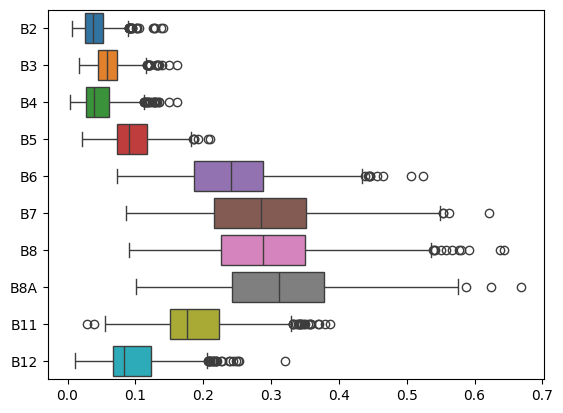

In [66]:
sns.boxplot(data = train_set[bandas], orient = "h");

### Preparacion de features

In [67]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train[bandas]), columns=bandas)
X_test = pd.DataFrame(scaler.transform(X_test[bandas]), columns=bandas)

### Construccion de modelo base

In [68]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)


LinearRegression()

Para train

In [84]:
y_pred = lin_reg.predict(X_train)

In [85]:
argumentos = (y_train, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', lin_reg.score(X_train, y_train))

MSE: 1.2840736146869636
RMSE: 1.1331697201597666
MAE: 0.8769993682659283
MAPE: 1.3693926252671573
R2: 0.5927897691638995


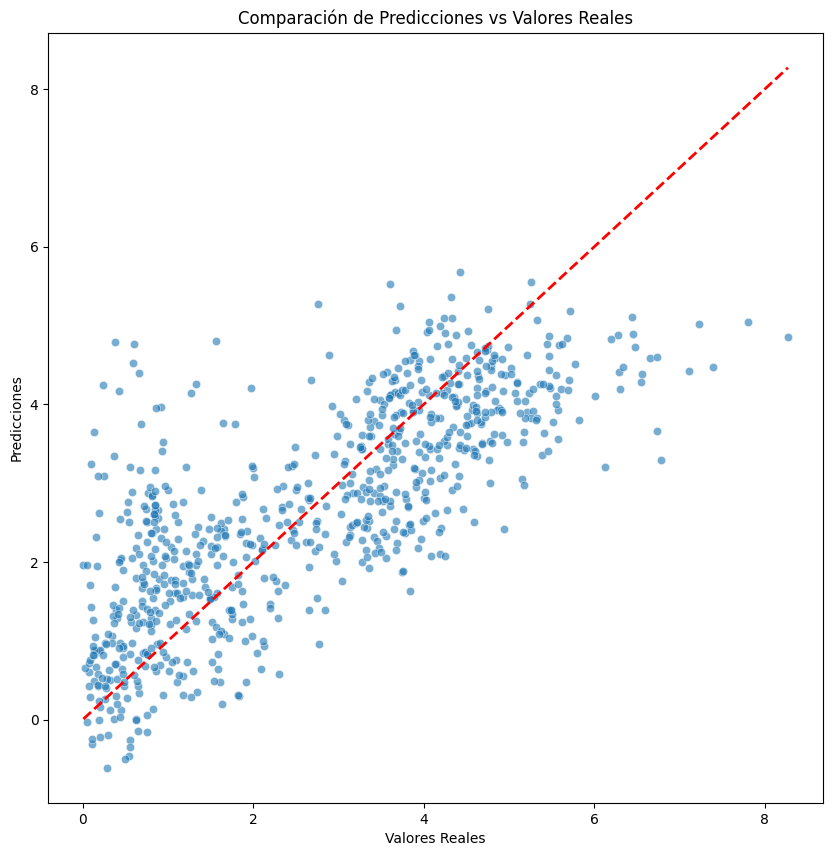

In [86]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_train, y=y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()

Para test

In [87]:
y_pred = lin_reg.predict(X_test)

argumentos = (y_test, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', lin_reg.score(X_test, y_test))

MSE: 1.2955605807071353
RMSE: 1.1382269460468484
MAE: 0.8520634909536093
MAPE: 1.2120473107761516
R2: 0.595672026983217


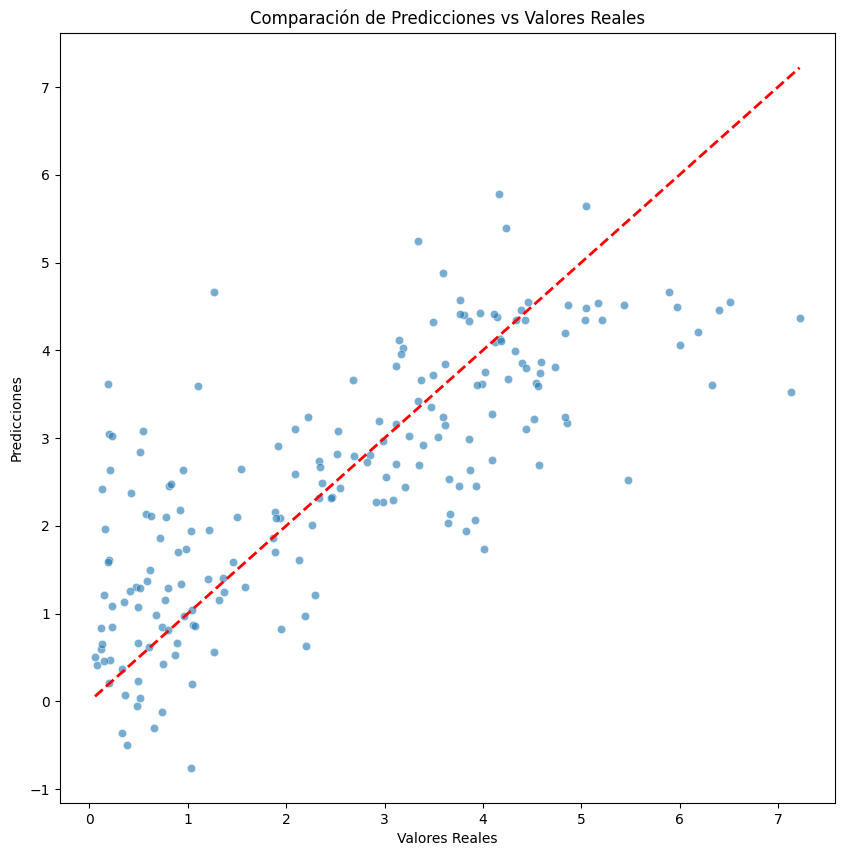

In [88]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()